In [19]:
from recommender_clustering import run_experiment
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os

def compute_metrics_single(dataset_name='ml-small', method='hard', n_clusters_range=range(2, 101, 5), top_k_val=10):
    nmae_list = []
    nrmse_list = []
    entropy_list = []

    for n in tqdm(n_clusters_range, desc='Ejecutando experimentos'):
        nmae, nrmse, entropy = run_experiment(dataset_name=dataset_name, method=method, n_clusters_val=n, top_k_val=top_k_val)
        nmae_list.append(nmae)
        nrmse_list.append(nrmse)
        entropy_list.append(entropy)

    return nmae_list, nrmse_list, entropy_list


def plot_metrics_single(n_clusters_range, nmae_list, nrmse_list, entropy_list):
    # Gráfica 1: NMAE
    plt.figure(figsize=(12, 6))
    plt.plot(n_clusters_range, nmae_list, label='NMAE', marker='o')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Valor')
    plt.title('NMAE vs Número de Clusters')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Gráfica 1: NRSME
    plt.figure(figsize=(12, 6))
    plt.plot(n_clusters_range, nrmse_list, label='NRMSE', marker='s', color='orange')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Valor')
    plt.title('NRSME vs Número de Clusters')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Gráfica 2: Entropía
    plt.figure(figsize=(12, 6))
    plt.plot(n_clusters_range, entropy_list, label='Entropy', marker='^', color='purple')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Entropía')
    plt.title('Entropía vs Número de Clusters')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def compute_metrics_all(
    dataset_names=['ml-small', 'ml-1m', 'books', 'jester'],
    method='hard',
    n_clusters_range=range(2, 101, 5),
    top_k_val=10,
    output_file='results.csv'
):
    """
    Ejecuta run_experiment para cada dataset en dataset_names
    y para cada valor de n_clusters en n_clusters_range.
    Guarda resultados en un CSV y permite resume si se interrumpe.
    """
    # Si existe archivo de resultados, cargar para saber qué ya se computó
    if os.path.exists(output_file):
        df_existing = pd.read_csv(output_file)
    else:
        # Crear DataFrame vacío con las columnas deseadas
        df_existing = pd.DataFrame(columns=[
            'dataset', 'method', 'n_clusters', 'top_k',
            'nmae', 'nrmse', 'entropy'
        ])

    # Iterar, saltar combinaciones ya en el archivo
    for ds in dataset_names:
        for n in tqdm(n_clusters_range, desc=f'Procesando {ds} ({method})'):
            # Verificar si ya existe esta configuración
            if not df_existing[
                (df_existing.dataset == ds) &
                (df_existing.method == method) &
                (df_existing.n_clusters == n) &
                (df_existing.top_k == top_k_val)
            ].empty:
                continue

            # Ejecutar experimento
            nmae, nrmse, entropy = run_experiment(
                dataset_name=ds,
                method=method,
                n_clusters_val=n,
                top_k_val=top_k_val
            )

            # Construir fila y escribir en CSV (modo append)
            row = {
                'dataset': ds,
                'method': method,
                'n_clusters': n,
                'top_k': top_k_val,
                'nmae': nmae,
                'nrmse': nrmse,
                'entropy': entropy
            }
            df_row = pd.DataFrame([row])
            df_row.to_csv(
                output_file,
                mode='a',
                header=not os.path.exists(output_file),
                index=False
            )

            # Agregar a df_existing para evitar recálculos en la misma ejecución
            df_existing = pd.concat([df_existing, df_row], ignore_index=True)

    print(f"Resultados guardados en {output_file}.")

def plot_metrics_all(results, n_clusters_range):
    """
    Dibuja tres gráficas (NMAE, NRMSE, Entropía) superponiendo
    las curvas de cada dataset contenidas en `results`.
    
    - results: dict devuelto por compute_metrics_all
    - n_clusters_range: iterable con los mismos valores usados al calcular
    """
    # Define estilos y marcadores para cada dataset
    estilos = {
        'ml-small': {'marker':'o', 'linestyle':'-', 'label':'MovieLens Small'},
        'ml-1m':    {'marker':'s', 'linestyle':'--','label':'MovieLens 1M'},
        'books':    {'marker':'^', 'linestyle':'-.','label':'Books'},
        'jester':   {'marker':'d', 'linestyle':':', 'label':'Jester'}
    }

    # 1) NMAE
    plt.figure(figsize=(12,6))
    for ds, mets in results.items():
        plt.plot(
            n_clusters_range,
            mets['nmae'],
            marker=estilos[ds]['marker'],
            linestyle=estilos[ds]['linestyle'],
            label=estilos[ds]['label']
        )
    plt.xlabel('Número de Clusters')
    plt.ylabel('NMAE')
    plt.title('Comparativa NMAE vs Número de Clusters')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig('../Memoria/Figuras/nmae-hard-all.png')
    plt.show()

    # 2) NRMSE
    plt.figure(figsize=(12,6))
    for ds, mets in results.items():
        plt.plot(
            n_clusters_range,
            mets['nrmse'],
            marker=estilos[ds]['marker'],
            linestyle=estilos[ds]['linestyle'],
            label=estilos[ds]['label']
        )
    plt.xlabel('Número de Clusters')
    plt.ylabel('NRMSE')
    plt.title('Comparativa NRMSE vs Número de Clusters')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig('../Memoria/Figuras/nrmse-hard-all.png')
    plt.show()

    # 3) Entropía
    plt.figure(figsize=(12,6))
    for ds, mets in results.items():
        plt.plot(
            n_clusters_range,
            mets['entropy'],
            marker=estilos[ds]['marker'],
            linestyle=estilos[ds]['linestyle'],
            label=estilos[ds]['label']
        )
    plt.xlabel('Número de Clusters')
    plt.ylabel('Entropía')
    plt.title('Comparativa Entropía vs Número de Clusters')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig('../Memoria/Figuras/entropy-hard-all.png')
    plt.show()



## Kmeans Euclidean

Ejecutando experimentos: 100%|██████████| 20/20 [01:44<00:00,  5.20s/it]


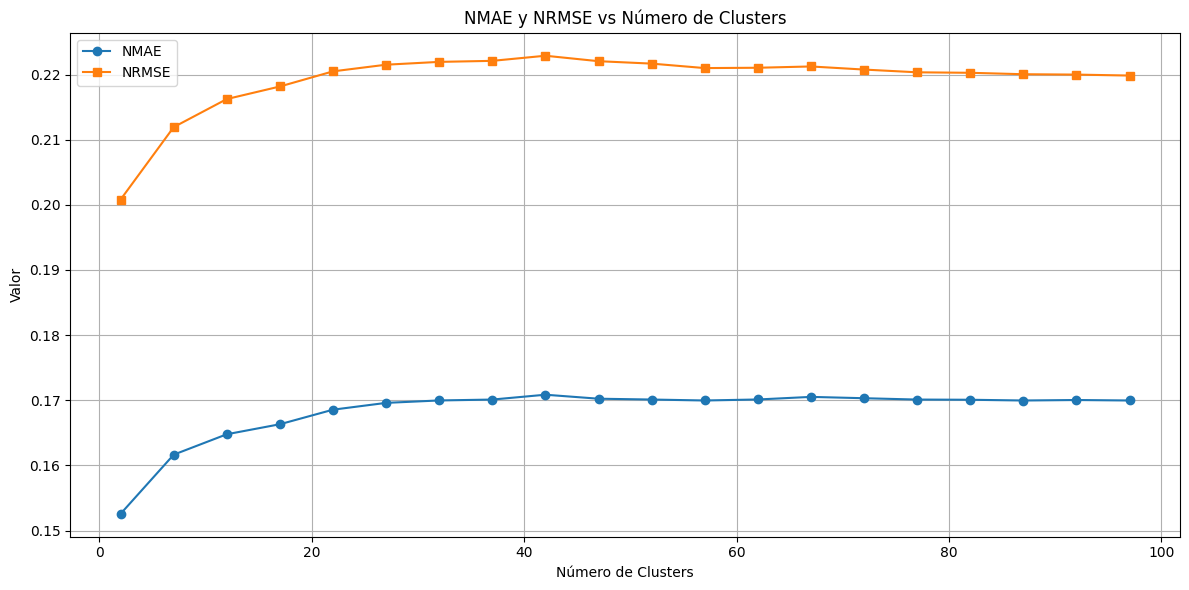

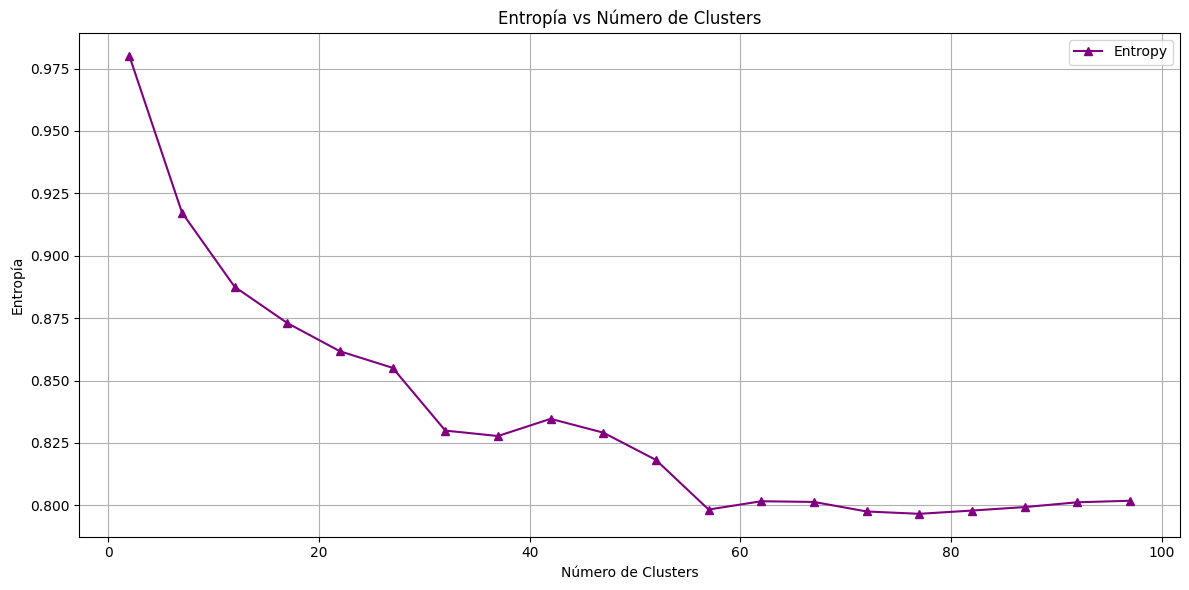

In [ ]:
n_clusters_range = range(2, 101, 5)
nmae_list, nrmse_list, entropy_list = compute_metrics_single(dataset_name='ml-small', method='hard', n_clusters_range=n_clusters_range, top_k_val=10)
plot_metrics_single(n_clusters_range, nmae_list, nrmse_list, entropy_list)


Procesando jester: 100%|██████████| 20/20 [09:04<00:00, 27.24s/it]


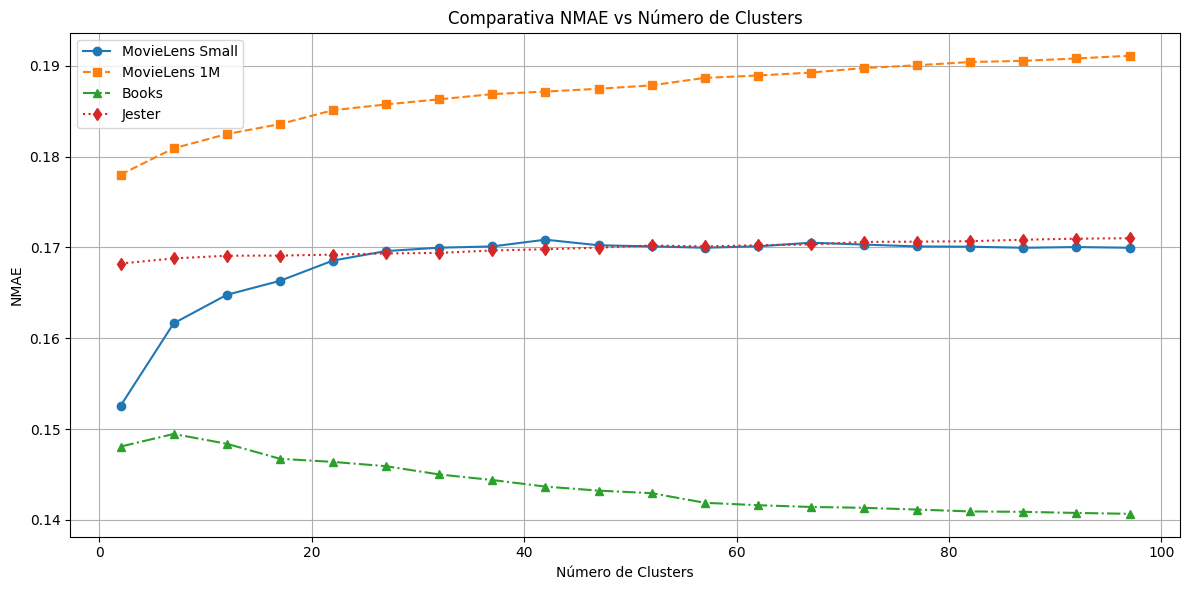

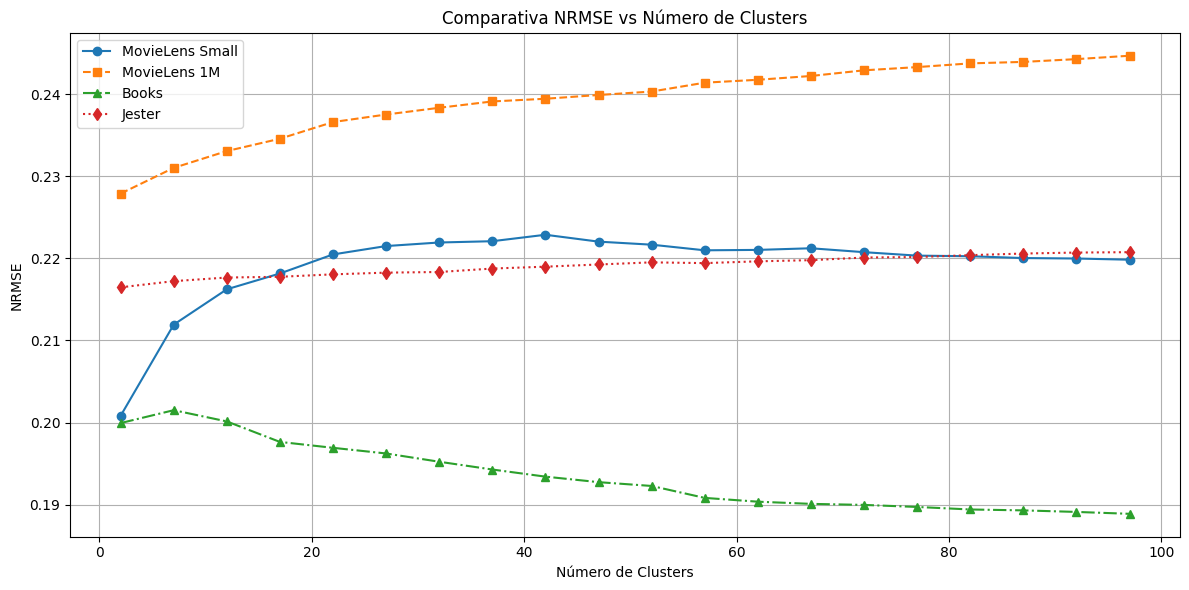

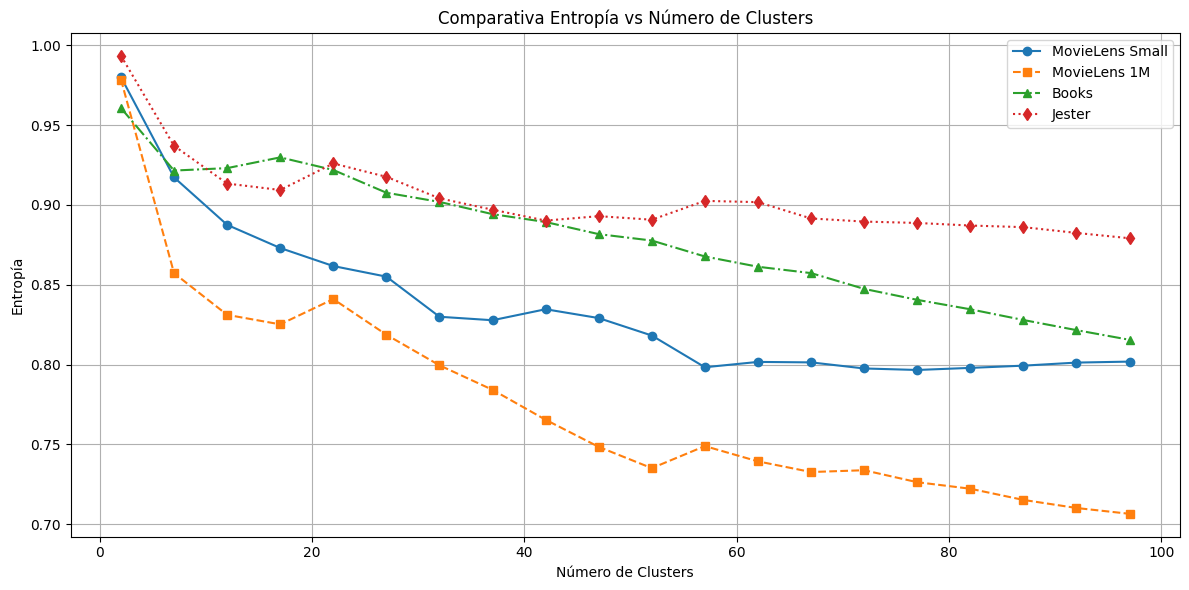

In [12]:
# 1) Calculamos todas las métricas
n_clusters = range(2, 101, 5)
results = compute_metrics_all(
    dataset_names=['ml-small','ml-1m','books','jester'],
    method='hard',
    n_clusters_range=n_clusters,
    top_k_val=10
)

# 2) Dibujamos las curvas comparativas
plot_metrics_all(results, n_clusters)


Procesando jester: 100%|██████████| 20/20 [28:59<00:00, 86.97s/it]


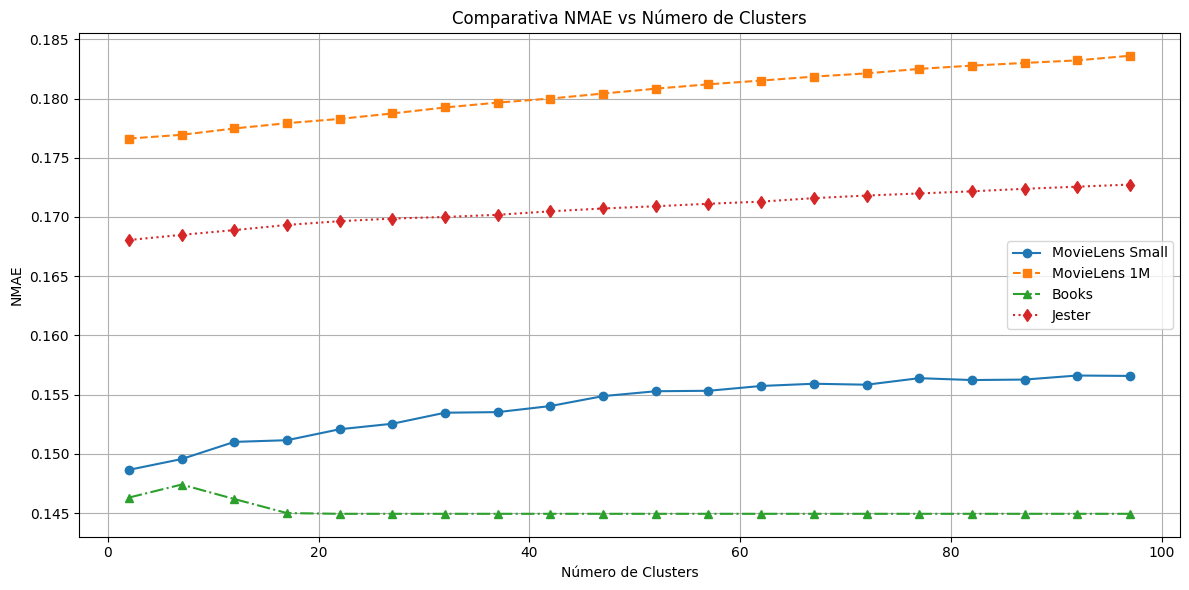

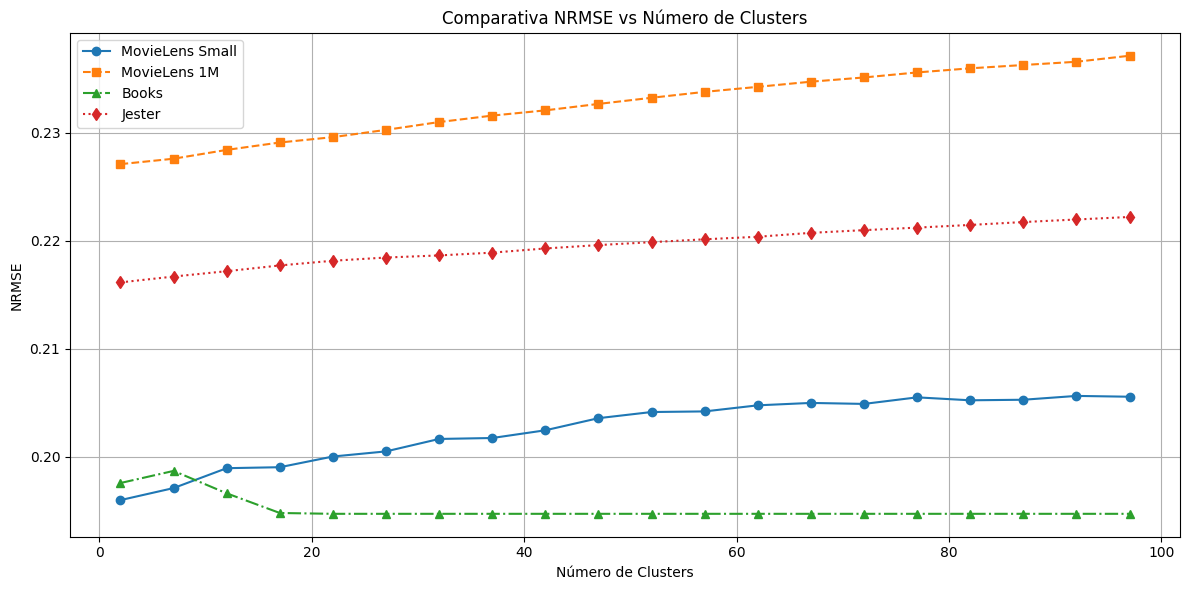

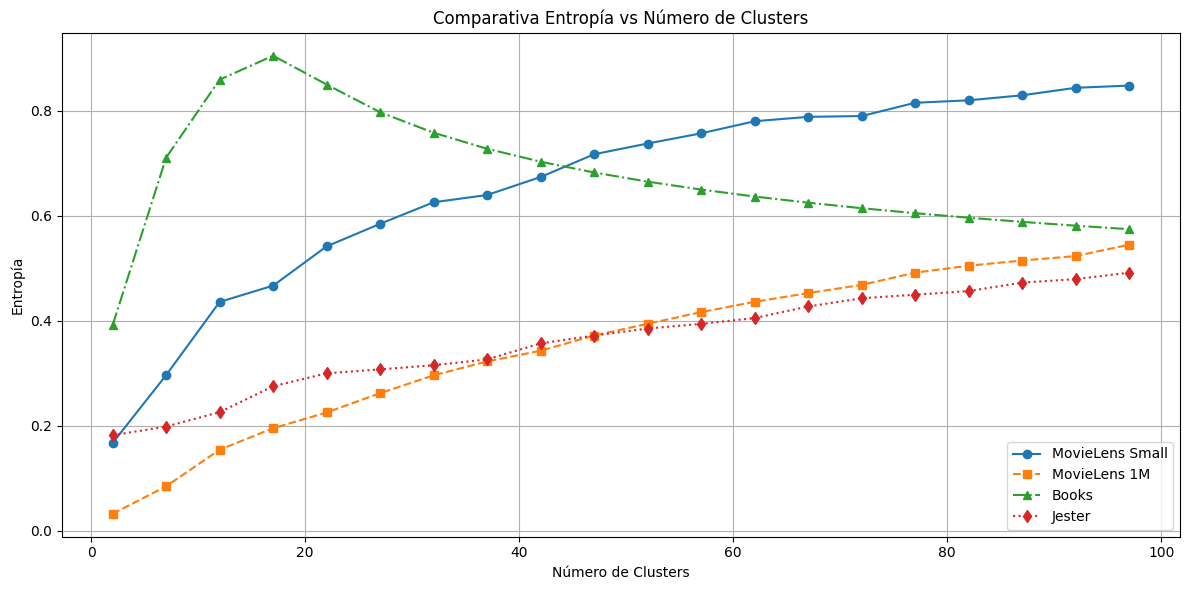

In [16]:
# 1) Calculamos todas las métricas
n_clusters = range(2, 101, 5)
results = compute_metrics_all(
    dataset_names=['ml-small','ml-1m','books','jester'],
    method='hac_pearson',
    n_clusters_range=n_clusters,
    top_k_val=10
)

# 2) Dibujamos las curvas comparativas
plot_metrics_all(results, n_clusters)

In [ ]:
n_clusters = range(2, 101, 5)
compute_metrics_all(
    dataset_names=['ml-small','ml-1m','books','jester'],
    method='hard',
    n_clusters_range=n_clusters,
    top_k_val=10
)

n_clusters = range(2, 101, 5)
compute_metrics_all(
    dataset_names=['ml-small','ml-1m','books','jester'],
    method='hard_pearson',
    n_clusters_range=n_clusters,
    top_k_val=10
)

n_clusters = range(2, 101, 5)
compute_metrics_all(
    dataset_names=['ml-small','ml-1m','books','jester'],
    method='fuzzy',
    n_clusters_range=n_clusters,
    top_k_val=10
)

n_clusters = range(2, 101, 5)
compute_metrics_all(
    dataset_names=['ml-small','ml-1m','books','jester'],
    method='fuzzy_pearson',
    n_clusters_range=n_clusters,
    top_k_val=10
)

Procesando jester (hard): 100%|██████████| 20/20 [00:00<00:00, 2413.36it/s]


Resultados guardados en results.csv.


Procesando jester (hard_pearson): 100%|██████████| 20/20 [00:00<00:00, 2311.87it/s]


Resultados guardados en results.csv.


Procesando ml-1m (fuzzy):  15%|█▌        | 3/20 [04:25<26:02, 91.90s/it]